In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array, array_to_img

from keras import Model
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
vgg = VGG16()

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
def predict_image_using_vgg(img_path, vgg):
    """
    Open image, convert it to an array, and run predictions
    using a trained model.
    """
    # load an image from file
    image = load_img(img_path, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape(
        (1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    y_pred = vgg.predict(image)
    labels = decode_predictions(y_pred)[0]
    for label in labels:
        print(label)
        

In [4]:
predict_image_using_vgg('../img/mug.jpg', vgg)

('n03063599', 'coffee_mug', 0.75266147)
('n03063689', 'coffeepot', 0.08365984)
('n07930864', 'cup', 0.06440081)
('n04398044', 'teapot', 0.030264238)
('n03950228', 'pitcher', 0.025889609)


### Creating a dataset

In [6]:
import os
import glob
import numpy as np

def create_dataset(folder):
    all_images = []
    image_arrays = []
    all_labels = []
    filenames = []
    for class_id, label in enumerate(os.listdir(folder)):
        print(class_id, label)
        for filename in glob.glob(folder + '/{}/*'.format(label)):
            filenames.append(filename)
            im = load_img(filename, target_size=(224, 224))
            all_images.append(im)
            preprocessed = preprocess_input(img_to_array(im))
            image_arrays.append(preprocessed)
            all_labels.append(class_id)
    X = np.array(image_arrays)
    Y = to_categorical(np.array(all_labels))
    return X, Y, filenames, all_images

In [8]:
X.shape

(502, 224, 224, 3)

In [9]:
X[0][:2,:2]

array([[[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]]], dtype=float32)

In [7]:
X, Y, filenames, all_images = create_dataset('../img/musicalInstruments')

0 piano
1 saxophone
2 violon


In [11]:
X.shape, Y.shape, len(filenames), len(all_images)

((502, 224, 224, 3), (502, 3), 502, 502)

In [12]:
Y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [13]:
filenames[:3]

['../img/musicalInstruments/piano/shopping-12.jpeg',
 '../img/musicalInstruments/piano/images-8.jpeg',
 '../img/musicalInstruments/piano/images-96.jpeg']

('n02236044', 'mantis', 0.25959602)
('n04141076', 'sax', 0.1109666)
('n03495258', 'harp', 0.095364295)
('n02231487', 'walking_stick', 0.06255506)
('n03532672', 'hook', 0.039617334)


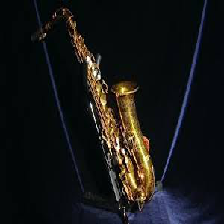

In [14]:
img_id = 248
predict_image_using_vgg(filenames[img_id], vgg)
all_images[img_id]

####  TODO Commentaire sur le résultat de VGG16 (est-ce que les classes ont du sens pour notre example ou pas)
#### Les classes ont du sens pour notre exemple, en effet il pense qu'il s'agit d'un saxophone à 11%, mais on peut mieux faire! En effet, il pense majoritairement (à 26%) qu'il s'agit d'une mante, ce qui n'est pas le cas! Nous allons donc essayer d'améliorer la prédiction sur notre example!


### Transfer learning

In [17]:
# Charger VGG-16 pré-entraîné sur ImageNet
# mais sans les couches fully-connected
vgg_cut = VGG16(weights="imagenet", include_top=False,
                input_shape=(224, 224, 3))
x = vgg_cut.output
# transform matrix into 1-d vector
x = Flatten()(x)

# TODO essayer de modifier le nombre de neurones  
x = Dense(15, activation='relu')(x) 

nb_classes = 3
x = Dense(nb_classes, activation='softmax')(x)  



#### Nous avons ici réduit le nombre de neurones à 15, en effet, il n'est pas utile d'en avoir 30 lorsque nous n'avons que 3 classes

In [18]:
custom_model = Model(inputs=vgg_cut.input, outputs=x)

In [19]:
# stratégie de Transfer Learning: extraction de features
# On entraîne seulement le nouveau classificateur,
# et on NE ré-entraîne PAS les autres couches.
# On utilise les autres couches uniquement pour 
# extraire des features des images
for layer in custom_model.layers[:-2]:
    layer.trainable = False

In [20]:
custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [21]:
# Compiler le modèle 
custom_model.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(lr=0.0001, momentum=0.9),
    metrics=["accuracy"])

#### On remarque ici que 10 époque n'est pas utile pour notre example. En effet, ici, nous observons qu'au bout de 8 époques nous atteignons presque les 100% précision! Essayons donc avec 8 époques

WARNING:tensorflow:From /home/mick/Workplace/DAR/myEnv/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
502/502 [==============================] - 134s 267ms/step - loss: 0.6670 - acc: 0.9442
Epoch 2/10
502/502 [==============================] - 135s 269ms/step - loss: 0.3628 - acc: 0.9761
Epoch 3/10
502/502 [==============================] - 134s 268ms/step - loss: 0.2264 - acc: 0.9841
Epoch 4/10
502/502 [==============================] - 137s 272ms/step - loss: 0.0735 - acc: 0.9940
Epoch 5/10
502/502 [==============================] - 135s 270ms/step - loss: 0.0704 - acc: 0.9940
Epoch 6/10
502/502 [==============================] - 135s 268ms/step - loss: 0.0483 - acc: 0.9960
Epoch 7/10
502/502 [==============================] - 134s 267ms/step - loss: 0.0833 - acc: 0.9940
Epoch 8/10
502/502 [==============================] - 134s 267ms/step - loss: 1.3928e-07 - acc: 1.0000
Epoch 9/10
502/502 [==============================] - 134s 267ms/step - loss: 1.3916e-07 - acc: 1.0000
Epoch 10/10
502/502 [==============================] - 135s 270ms/step - loss: 1.3916e-07 - acc: 1.0000


In [22]:
# Entraîner sur toutes les données
# (X_train, Y_train)
custom_model.fit(X, Y,
                 epochs=8, batch_size=5)
# TODO essayer de changer epochs=3 (5, 10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/8
502/502 [==============================] - 133s 265ms/step - loss: 0.8404 - acc: 0.9363
Epoch 2/8
502/502 [==============================] - 135s 269ms/step - loss: 0.0853 - acc: 0.9900
Epoch 3/8
502/502 [==============================] - 134s 266ms/step - loss: 0.0457 - acc: 0.9920
Epoch 4/8
502/502 [==============================] - 134s 266ms/step - loss: 0.0621 - acc: 0.9920
Epoch 5/8
502/502 [==============================] - 134s 267ms/step - loss: 8.0755e-07 - acc: 1.0000
Epoch 6/8
502/502 [==============================] - 134s 268ms/step - loss: 7.5483e-07 - acc: 1.0000
Epoch 7/8
502/502 [==============================] - 135s 270ms/step - loss: 7.1196e-07 - acc: 1.0000
Epoch 8/8
502/502 [==============================] - 135s 269ms/step - loss: 6.7907e-07 - acc: 1.0000


#### On remarque encore une fois qu'on atteint 100% de précision mais cette fois au bout de 5 époques, gardons cependant 8 époques, pour s'assurer d'atteindre ces 100% de précision !

#### Utilisons notre modèle entrainé pour faire des prédictions sur les images de test

In [23]:
# télécharger les images de test (sans libellé, tout dossier TEST)
def load_test_set(folder):
    all_images = []
    image_arrays = []
    filenames = []
    for filename in glob.glob(folder + '/*'):
        filenames.append(filename)
        im = load_img(filename, target_size=(224, 224))
        all_images.append(im)
        preprocessed = preprocess_input(img_to_array(im))
        image_arrays.append(preprocessed)
    X = np.array(image_arrays)
    return X, filenames, all_images

In [25]:
X_test, test_filenames, test_images = load_test_set(
    '../img/musicalInstruments_test/')

In [26]:
X_test.shape

(8, 224, 224, 3)

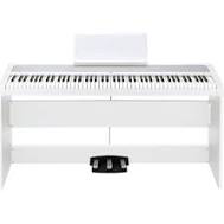

In [27]:
test_id = 1
test_images[test_id]

In [28]:
img_reshaped = X_test[test_id].reshape(1, *X_test[test_id].shape)
custom_model.predict(img_reshaped)

array([[1.000000e+00, 0.000000e+00, 3.241197e-35]], dtype=float32)

#### Il nous prédit avec (presque) 100% de précision qu'il s'agit de la classe 0 (piano) ce qui est juste! Essayons avec un autre test !

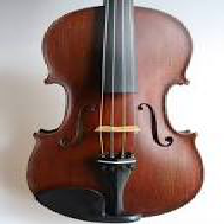

In [32]:
test_id2 = 0
test_images[test_id2]

In [33]:
img_reshaped2 = X_test[test_id2].reshape(1, *X_test[test_id2].shape)
custom_model.predict(img_reshaped2)

array([[0., 0., 1.]], dtype=float32)

#### Il nous prédit avec (presque) 100% de précision qu'il s'agit de la classe 2 (violon) ce qui est juste! On observe assi que dans notre image de test, le violon n'est pas en entier mais que notre modèe arrive quand même à le prédire.  Essayons avec un autre test !

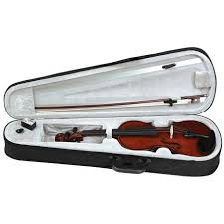

In [35]:
test_id3 = 3
test_images[test_id3]

In [36]:
img_reshaped3 = X_test[test_id3].reshape(1, *X_test[test_id3].shape)
custom_model.predict(img_reshaped3)

array([[0.0000000e+00, 1.6184867e-14, 1.0000000e+00]], dtype=float32)

#### Il nous prédit avec (presque) 100% de précision qu'il s'agit de la classe 2 (violon) ce qui est juste! Cette fois-ci il est intéressant de faire remarquer qu'il s'agit d'un violon dans son étuis mais qu'il réussit quand même à prédire qu'il s'agit d'un violon, il aurait en effet pu le confondre avec un piano (à cause des couleur et de la forme du boitier) Essayons avec un dernier example !

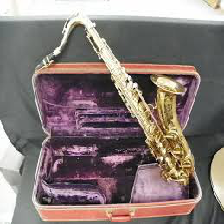

In [42]:
test_id4 = 7
test_images[test_id4]

In [43]:
img_reshaped4 = X_test[test_id4].reshape(1, *X_test[test_id4].shape)
custom_model.predict(img_reshaped4)

array([[0.000000e+00, 1.000000e+00, 7.050688e-37]], dtype=float32)

#### En voila un autre test intéressant, il s'agit d'un saxophone qu'il arrive à prédire avec 100% de précision, mais cette fois-ci, il s'agit d'un saxophone avec son étuis ! Nous avons donc observé que notre modèle reconnait bien les différentes classes même si elles ne sont pas dans le même contexte. Ce résultat nous a été permi du fait que l'on lui fournis une bonne quantité d'entrainement ainsi qu'une bonne quantité d'image assez différente.

### En conclusion, après avoir bien épurgé nos données ainsi qu'après avoir bien choisi des données assez différentes pour que notre modèle s'entraine sur un plus grand nombre de variants possible. Nous avons essayé d'entraîner notre modèle sur un nombre d'époques différent, nous nous sommes finalement arreter sur le choix de 8 époques, fusionnant précision élevée ainsi que temps de calcul le plus court possible.
### Notre modèle a donc finalement un assez bon score de prédiction et prédit bien pour les différentes image de tests que nous avons !

# Projet
1. Trouver le sujet de classification d'images
2. Créer le jeu de données:
    * Télécharger les images de l'Internet
    * Utiliser le plugin ""Download All Images"" de navigateur pour aller plus vite:
    * Saisir la requete sur Google Images (par exemple)
    * Cliquer sur "Download All Images" (le plugin du navigateur)
    * Dézipper le fichier téléchargé
    * Récupérer seulement des images pertinentes
    * Mettre ces images dans votre arboscence:
        "img/<nom_de_l_equipe>/<un_dossier_par_catégorie>/*.png"
    * Créer des matrices X et Y à partir des images:
        * itérateur sur les dossiers et les images;
        * chargement des images;
        * preprocessing lié à VGG16 (ou autre modèle CNN préentrainé que vous allez utiliser);
        * création du numpy.array finale depuis la liste des images chargés et prétraités;
        * création du vecteur de "labels" à partir des noms de dossiers parcourus, pour chaque image ("adidas adidas adidas cocacola cocacola fdj fdj fdj fdj ....");
        * conversion du vecteur 1-dimensionnel de labels en vecteur M-dimensionnel, où M = nombre de catégories de votre problème: pour cela, utiliser la fonction *to_categorical*. Chaque label doit donc être un vecteur avec des 0.0 et une seule valeur 1.0 sur la position qui correspond à la bonne catégorie.
        
3. Utiliser un des modèles CNN (convolutional neural network) déjà entrainé (comme VGG ou autre, cf. ici https://keras.io/applications/) pour faire des prédictions sur quelques images de votre dataset. Utiliser "decode_predictions" pour afficher à quelles classes appartient des valeurs maximales du vecteur de prédiction

* Comme votre use case est spécifique, et les classes présentes dans le modèle VGG ne correspondent pas à votre problème. Il faut donc faire du Transfer Learning:
    * Prendre un modèle pré-entrainé (VGG par exemple), mais ne pas utiliser sa dernière couche! (include_top=False). Ne pas oublier de spécifier le format des images en entrée ((224, 224, 3) pour VGG). 
    * Ajouter une couche Flatten() pour aplaitir la matrice pour obtenir le vecteur 1-dimensionnel.
    * Ajouter une couche Dense(nb_classes, activation="softmax")
    * Créer un modele *custom* qui va utiliser ces couches-là.
    * Comme le modèle VGG sera en version "cut" ("truncated"), donc elle ne sera pas utilisé pour les prédictions mais seulement pour extraction de features. Donc, il faut préciser que les couches du modèle custom soit déclarés comme "layer.trainable = False". Utiliser l'itérateur sur "custom_model.layers" afin de préciser quelles couches ne pas entrainer.
    * Vérifier avec "custom_model.summary()" que seulement les paramètres qui correspondent à la dernière couche Dense seront entrainés (cf. les messages "Total parameters, Trainable parameters, Non-Trainable parameters" du summary.
    * Déclarer la méthod de "compilation" du modèle (fonction de perte, algorithme, métrique) avec "custom_model.compile(....)"
    * Finalement, ENTRAINER le modèle avec la commande "custom_modèle.fit". Utiliser plusieurs nombre de *epochs* (plus est mieux, quitte à laisser le modèle s'entrainer pendant plusieurs heures); varier le *batch_size* en fonction de nombre totale d'images dans votre dataset (batch_size plus élevé accélère l'entrainement mais dégrade le résultat; par contre valeur 1 risque de finir par le "overfit", "surapprentissage", où le modèle va apprendre par coeur des exemple, mais mal généraliser sur des nouvelles images, donc le score sera mauvais aussi. Trouver la bonne valeur de batch_size, commenter les étapes de votre expérimentation.
    
    
* Charger des images depuis le dossier "img/test_images", utiliser le même prétraitement afin d'avoir le même format que des matrices X (pas besoin de Y ici, car vous allez juste lancer des prédictions).
* Lancer des prédictions sur ces nouvelles images (custom_model.predict).
* Interpréter des prédictions. Quelle catégorie donne la proba maximale?  Afficher l'image dans notebook pour voir ce qu'elle représente. Est-ce que c'est la bonne catégorie qui a été prédite?


#### Faire un résumé du projet: qu'est-ce que vous avez fait, quels résultats obtenus. Quel score a votre modèle, est-ce qu'elle prédit bien sur des images de test.
#### Commentez votre code!!! 
    
### livrables: GITHUB!!! code + images + requirements.txt, la même arborescence que dl MAIS SANS DOSSIER MYENV!!!  requirements.txt suffira pour recréer "myenv" lors de la correction

### denis.lazarenko@gmail.com


### deadline: 28 avril 2019 , 23:59:59
### questions par mail


#### Liens utils
* training Keras models: 
  https://keras.io/getting-started/sequential-model-guide/
* deep learning tutorial: https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/
* convolution filter produces a feature map (animation): https://www.youtube.com/watch?v=KiftWz544_8